# Impact of Outliers In Supervised Machine Learning Classifiers 

# Project Overview

This project focuses on a classification problem using data from the Online Encyclopedia of Integer Sequences (OEIS) where the task is to predict whether the tenth sequence value of a sequence is larger than the ninth, based on the first nine sequence values. Even though sequence learning type problems usually are handled by recurrent neural networks, deep learning is beyond the scope of this course and benchmark results for this comparatively simpler problem will be determined using other supervised techniques. In particular logistic regression, AdaBoost and XGBoost are utilized. 

This classification task could potentially be useful for downstream deep learning tasks as training a single model on all sequences from OEIS may not be feasible. The sequence structure may allow for partitioning of sequences and construction of multiple models and the output of an initial classifier can inform how the sequences should be divided for this. 

The motivation for this project extends beyond achieving optimal model performance.  Additional emphasis is placed on understanding the effect of outliers on logistic regression,  AdaBoost and XGBoost . A larger data set with outliers and a pruned data set will be compared for effectiveness in training these classifiers. Further out-of-distribution generalizability will be studied to understand which of the algorithms fitted on the smaller data are robust to making predictions on the larger data set with outliers. OEIS is a good choice of data set due to many atypical sequences.

Imbalanced data is  commonplace in this work and so multiple classification metrics beyond accuracy are considered along with their strengths and weaknesses for this particular data set 

The github repository link is located here: https://github.com/HeTalksInMaths/SupMLProj-OEIS

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Loading Data

The data comes from the Online Encyclopedia of Integer Sequences https://oeis.org/ (Sloane, 1964). This notebook is self-contained and the data is downloaded from a public Google Drive folder. Files were originally downloaed from https://davidbieber.com/snippets/2020-06-28-oeis-download/ (Bieber, 2020).



In [2]:
fileid='1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip'
filename='oeisvals.csv'

!wget -O $filename 'https://docs.google.com/uc?export=download&id='$fileid


--2022-08-14 13:19:15--  https://docs.google.com/uc?export=download&id=1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip
Resolving docs.google.com (docs.google.com)... 142.250.141.138, 142.250.141.139, 142.250.141.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fmq1enaqlvlpdmk2g2qkkefd3h6upm54/1660483125000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=1268fce8-d414-4ccf-b3cb-6fe19fa88e48 [following]
--2022-08-14 13:19:17--  https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fmq1enaqlvlpdmk2g2qkkefd3h6upm54/1660483125000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=1268fce8-d414-4ccf-b3cb-6fe19fa88e48
Resolving doc-0o-4k-docs.googleusercontent.com (doc-0o-4k-docs.googleusercontent.com)... 142.251.2.132, 2607:f8

The first ten values for each sequence are extracted from the full dataset for our purposes.


In [3]:
dfseq = pd.read_csv('/content/oeisvals.csv', header=None, skiprows=4, usecols=range(11), 
                    names=["Sequence", '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

for c in dfseq.columns[1:]:
  dfseq[c] = pd.to_numeric(dfseq[c], errors='coerce', downcast="integer")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
dfseq.head()

,Sequence,1,2,3,4,5,6,7,8,9,10
0,A000001,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,5.0,2.0
1,A000002,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0
2,A000003,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0
3,A000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A000005,1.0,2.0,2.0,3.0,2.0,4.0,2.0,4.0,3.0,4.0


To convert the data for our problem specification, the 2nd to 10th columns are our features with whether the value in the 11th column is larger than the 10th is our target we are aiming to predict.

The code below converts the above to the needed format.

In [5]:
y = np.where(dfseq['10'] > dfseq['9'], 1, 0) 
X = dfseq.drop(columns = ['Sequence', '10'])
X.head()

,1,2,3,4,5,6,7,8,9
0,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,5.0
1,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0
2,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2.0,2.0,3.0,2.0,4.0,2.0,4.0,3.0


In [6]:
y[:5]

array([0, 0, 0, 0, 1])

Note the 10th sequence value is larger than the 9th only in the 5th sequence of the first five as seen in dfseq.head().

# Initial Exploratory Data Analysis (EDA)

In [7]:
X.shape

(351519, 9)

There are over 350,000 integer sequences but not some may not have ten sequence values. These are dropped from the data. Note that the corresponding target values also need to be dropped.

In [8]:
flag = np.array(~(X.isnull().any(axis=1)).values)
X = X[flag]
y = y[flag]
X.shape

(335109, 9)

In [9]:
y.shape

(335109,)

Now there are 330,000 sequences however further reduction of the data set will be needed. 
 
Recall in logistic regression predicted probabilities are determined by $\sigma(X) = \frac{1}{1 + e^{-\beta \cdot X}}$ where $X$ comes from the data and $\beta$ are the learned weights. Outliers may unduly impact weight updates during the optimization algorithm for logistic regression.
 
We inspect the maximum, mean and median values. Normally a boxplot could be used to highlight the distribution but extreme outliers make obtaining a meaningful visualization difficult.


In [10]:
np.max(X, axis = 0)

1    1.111111e+127
2     3.402824e+38
3     1.000000e+63
4     2.975857e+79
5    9.046413e+110
6     1.111111e+86
7    2.222222e+205
8    1.307539e+167
9    1.341785e+154
dtype: float64

In [11]:
np.mean(X, axis = 0)

1    3.684079e+121
2     1.015497e+33
3     5.968207e+57
4     8.880964e+73
5    2.699543e+105
6     3.315671e+80
7    6.631342e+199
8    3.901832e+161
9    4.005770e+148
dtype: float64

In [12]:
np.median(X, axis=0)

array([  1.,   3.,   7.,  12.,  22.,  35.,  59.,  89., 128.])

As can be seen, large outlier values are resulting in means well above the median values. As stated earlier, it is hypothesized that these large values which are outliers will impact the optimization algorithm used for logistic regression. 

Floating point errors in training with such large numbers but even a slightly reduced data set of those sequences only having values between $-10^{10}$ and $10^{10}$ could face issues given the median values. This will be explored below. 

In [13]:
X_large_ub = X[(X[X.columns] < 1e10).sum(1) > 8] # values are upper bounded first
X_large = X_large_ub[(X_large_ub[X_large_ub.columns] > -1e10).sum(1) > 8]
y_large = y[(X[X.columns] < 1e10).sum(1) > 8] # corresponding targets determined
y_large = y_large[(X_large_ub[X_large_ub.columns] > -1e10).sum(1) > 8]

In [14]:
X_large.shape

(299957, 9)

In [15]:
y_large.shape

(299957,)

In [16]:
len(X_large)/len(X) * 100

89.51027874512472

89.5% of the data is retained on this first pass in understanding the impact of outliers. There are less than 300,000 sequences left with the first nine seqeunce values used as features for predcition.

In [17]:
np.mean(X_large, axis = 0)

1    1.777582e+06
2    1.902575e+06
3    2.132268e+06
4    2.665069e+06
5    3.163239e+06
6    3.930495e+06
7    5.823781e+06
8    1.428409e+07
9    9.346931e+07
dtype: float64

In [18]:
np.median(X_large, axis = 0)

array([ 1.,  3.,  5.,  9., 16., 24., 33., 48., 64.])

The right skew is still apparent but we build a logistic regression classifier on this data set. This will eventually be compared to using a substantially reduced data set with values between $-10^{3}$ and $10^{3}$ where further exploratory data analysis will be done.

In [19]:
np.mean(y_large)

0.7631693876122244

Note the class imbalance which will also inform which metrics are used in evaluation beyond accuracy alone. For this data set many more sequences have 10th sequence value larger than the 9th sequence value.

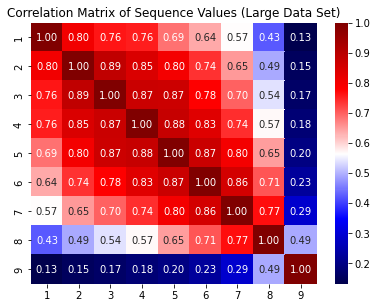

In [81]:
ax = sns.heatmap(X_large.corr(), annot = True, fmt = '.2f', cmap = 'seismic')
ax.set_title("Correlation Matrix of Sequence Values (Large Data Set)")
ax


 
 
Sequence values that are close to one another  in position on the sequence (near the diagonal) are more likely to be correlated, which is expected. By the ninth value, the correlation with the eighth value is considerably less for consecutive positions. Removing sequence values as features is worth considering but if the goal is optimizing solely prediction, it may not be ideal even if coefficients become less interpretable.



# Logistic Regression Model With Outliers

We use 90% of the data for training and make predictions on the remaining 10%. The random state is set for reproducibility. 

In [84]:
X_large_train, X_large_test, y_large_train, y_large_test = train_test_split(X_large, y_large, test_size=.1, random_state=0)
X_large_train.shape

(269961, 9)

In [85]:
np.mean(y_large_train)

0.7635139890576788

The training data has a similar class imbalance.

The model is constructed with random_state fixed for reproducibility and accuracy is reported on the test set. 

In [86]:
lr = LogisticRegression(random_state = 0) # not fitted so can be reused for different data sets
lr.fit(X_large_train, y_large_train)
lr_large_acc = lr.score(X_large_test, y_large_test)
lr_large_acc

0.7587344979330577

In [87]:
np.mean(y_large_test)

0.7600680090678757

The accuracy is worse than the baseline of predicting every target as 1 (10th sequence value larger than 9th). 

Adjusting the class weights to balanced is a first attempt to resolve the issue.

In [88]:
lr_bal = LogisticRegression(random_state=0, class_weight="balanced") # not fitted so can be reused later
lr_bal.fit(X_large_train, y_large_train)
lr_large_bal_acc = lr_bal.score(X_large_test, y_large_test)
lr_large_bal_acc

0.7598013068409121

In [89]:
lr_large_preds = lr.predict(X_large_test) 
lr_large_bal_preds = lr_bal.predict(X_large_test)
np.mean(lr_large_preds == lr_large_bal_preds)

0.9603947192959061

The problem persists with similar accuracy that is still below the baseline and the two models agree on their predictions over 96% of the time.

With the standard 0.5 threshold for prediction in logistic regression, the number of predicted increasing sequences between the 9th and 10th sequence value is determined.

In [90]:
np.mean(lr_large_preds)

0.9095879450593413

 
Almost 91% of sequences in training are predicted as increasing between the 9th and 10th sequence value which is substantially more than the actual percentage.

The predicted probabilities are inspected to understand the issue further.


In [91]:
lr.predict_proba(X_large_test)

array([[0.49999999, 0.50000001],
       [0.5       , 0.5       ],
       [0.49999988, 0.50000012],
       ...,
       [0.4999998 , 0.5000002 ],
       [0.5       , 0.5       ],
       [0.49999889, 0.50000111]])

Very few of the predicted probabilities are outside of 0.49 to 0.51.

In [92]:
lr_large_predprobs = lr.predict_proba(X_large_test)[:,1] # only need the probability of positive class, column inedx 1
a = sum(lr_large_predprobs > 0.51) 
a

2141

In [93]:
b = sum(lr_large_predprobs < 0.49)
b

34

In [94]:
(a + b) / len(X_large_test)

0.07250966795572743

In [95]:
np.mean(lr_large_predprobs)

0.5142342711634368

The mean of the predicted probabilities across sequences is very close to 0.5 even though almost 91% are above 0.5.
This is likely because the coefficients are very small due to the outliers driving them towards zero. The model is inspected and this is confirmed.


In [96]:
lr.coef_

array([[-9.24312628e-10, -4.04284890e-10,  5.18686430e-10,
         1.93835037e-10, -2.57218374e-09, -3.06453208e-10,
         4.80978676e-10,  2.01488181e-09,  1.15016728e-09]])


There appears to be very little "learning" going on with the model and a reduced data set should be considered. Standard classifier metrics for imbalanced data are determined for this model for further diagnostics (F$_{1}$ score, AUC) and as benchmarks for the reduced data set.

In [97]:
f1_lr_large = f1_score(y_large_test, lr_large_preds)
f1_lr_large

0.8554998702154424

In [98]:
roc_lr_large_dat = roc_curve(y_large_test, lr_large_predprobs)
auc_lr_large = roc_auc_score(y_large_test, lr_large_predprobs)
auc_lr_large

0.7866600154555823

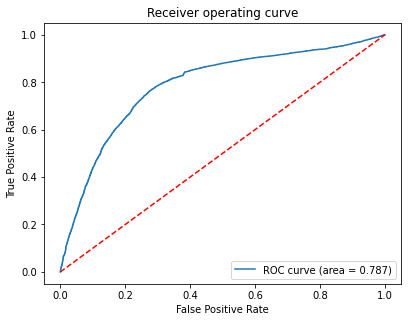

In [99]:
plt.plot(roc_lr_large_dat[0], roc_lr_large_dat[1], label="ROC curve (area = %0.3f)" % auc_lr_large)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating curve")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

 
Even with most predicted probabilities falling in a very small range, there is enough differentiation resulting in a predicted probability ordering that leads to a better than benchmark AUC.


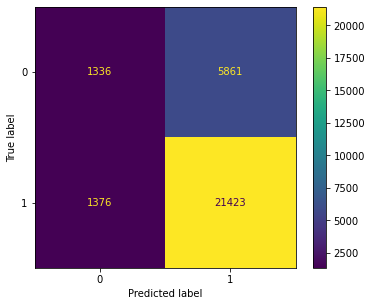

In [100]:
cm_lr_large = confusion_matrix(y_large_test, lr_large_preds)
disp = ConfusionMatrixDisplay(cm_lr_large)
disp.plot(values_format='')


While the AUC indicates reasonable performance, the confusion matrix shows that when the true label is negative (non-increasing 10th sequence values versus 9th) it is often misclassified (high false positive).



In [101]:
all_ones_large = len(y_large_test) * [1]
f1_bench_large = f1_score(y_large_test, all_ones_large)
f1_bench_large

0.8636802727531017

Thus the F$_{1}$ score for logistic regression does not outperform classifying every sequence as increasing from the 9th to 10th sequence values.

# More Expolartory Data Analysis (EDA)

Now we work with a substantially reduced data set with values between $-10^{3}$ and $10^{3}$.


In [102]:
X_small_ub = X[(X[X.columns] < 1e3).sum(1) > 8] # values are upper bounded first
X_small = X_small_ub[(X_small_ub[X_small_ub.columns] > -1e3).sum(1) > 8]
y_small = y[(X[X.columns] < 1e3).sum(1) > 8] # # corresponding targets determined
y_small = y_small[(X_small_ub[X_small_ub.columns] > -1e3).sum(1) > 8]

In [103]:
X_small.shape

(198141, 9)

In [104]:
y_small.shape

(198141,)

In [108]:
len(X_small)/len(X) * 100

59.127328719909045

In [109]:
len(X_small)/len(X_large) * 100

66.0564680937601

The smaller data set is under 60% of the original data set and 66% of the larger data set the prior logistic regression model was trained on. There are slightly under 200,000 sequences with the first nine sequence values as features.

We analyze the mean and median of the sequence values as well as construct boxplots and histograms to explore the distribution of values.

In [193]:
np.mean(X_small, axis = 0)

1     5.008746
2     8.505327
3    12.806037
4    18.058297
5    24.731388
6    32.575797
7    44.581429
8    61.007752
9    86.210744
dtype: float64

In [196]:
np.median(X_small, axis = 0)

array([ 1.,  2.,  3.,  5.,  6.,  8., 10., 13., 16.])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

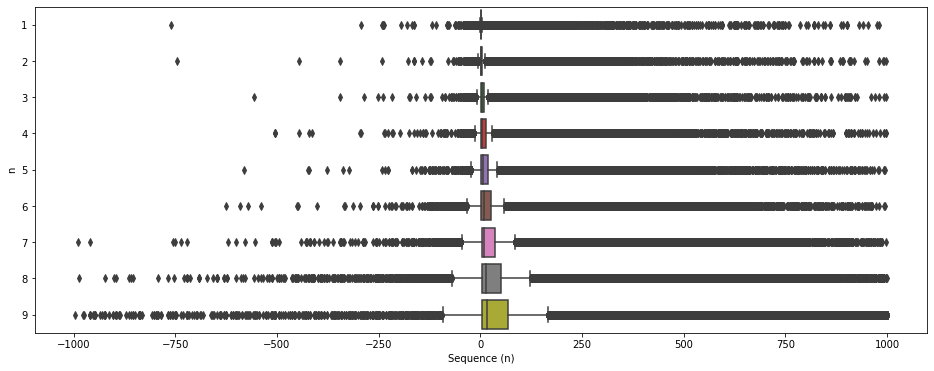

In [105]:
plt.rcParams["figure.figsize"] = (16,6)

X_small_plot = X_small.melt(id_vars = [], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot(y=X_small_plot["n"], x=X_small_plot["Sequence (n)"])

plt

Text(0.5, 1.0, 'Ninth Sequence Values')

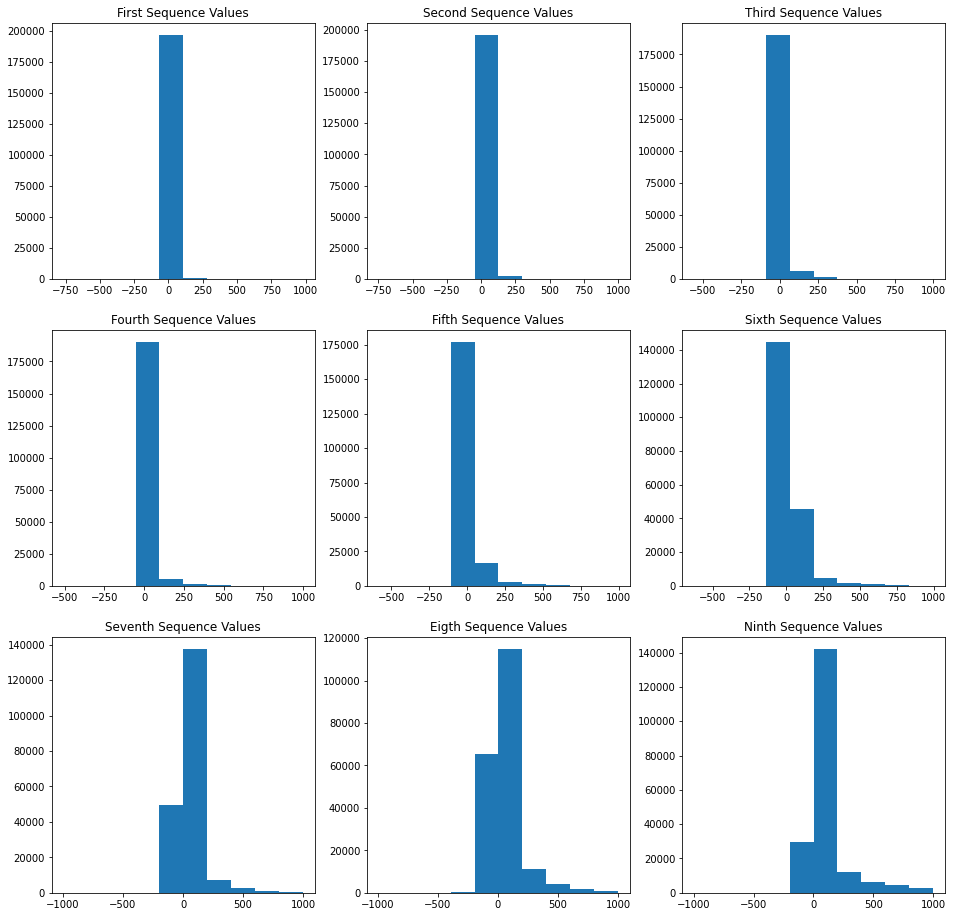

In [106]:
plt.rcParams["figure.figsize"] = (16,16)

fig, axs = plt.subplots(3, 3)
axs[0, 0].hist(X_small['1'])
axs[0, 0].set_title('First Sequence Values')
axs[0, 1].hist(X_small['2'])
axs[0, 1].set_title('Second Sequence Values')
axs[0, 2].hist(X_small['3'])
axs[0, 2].set_title('Third Sequence Values')
axs[1, 0].hist(X_small['4'])
axs[1, 0].set_title('Fourth Sequence Values')
axs[1, 1].hist(X_small['5'])
axs[1, 1].set_title('Fifth Sequence Values')
axs[1, 2].hist(X_small['6'])
axs[1, 2].set_title('Sixth Sequence Values')
axs[2, 0].hist(X_small['7'])
axs[2, 0].set_title('Seventh Sequence Values')
axs[2, 1].hist(X_small['8'])
axs[2, 1].set_title('Eigth Sequence Values')
axs[2, 2].hist(X_small['9'])
axs[2, 2].set_title('Ninth Sequence Values')

There are still plenty of outliers and right skew persists, but the extremely large values that are removed should no longer have as much impact on the weight updates. The means are not substantially larger than the medians as compared to before.








In [107]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset figure size

In [110]:
np.mean(y_small)

0.6820799329770214

There is still class imbalance but it is less significant than before. 

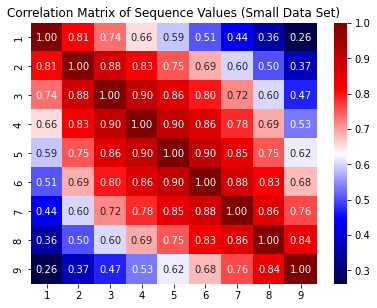

In [111]:
ax = sns.heatmap(X_small.corr(), annot = True, fmt = '.2f', cmap = 'seismic')
ax.set_title("Correlation Matrix of Sequence Values (Small Data Set)")
ax

As expected, sequence values in nearby positions are more correlated and this pattern is more pronounced in this reduced data set. Whether using only a subset of the sequence values (those near the 10th position) would lead to better performance is worth further consideration. 

# Logistic Regression On Reduced Data Set

Again we use 90% of the data for training and make predictions on the remaining 10%. The random state is set for reproducibility. 

In [112]:
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=.1, random_state=0)
X_small_train.shape

(178326, 9)

In [113]:
np.mean(y_small_train)

0.682143938629252

In [114]:
lr.fit(X_small_train, y_small_train)
lr_small_acc = lr.score(X_small_test, y_small_test)
lr_small_acc

0.6886197325258643

In [115]:
np.mean(y_small_test)

0.6815039111784003

In [116]:
lr_small_preds = lr.predict(X_small_test) 
np.mean(lr_small_preds)

0.9820842795861721

In [117]:
lr_small_predprobs = lr.predict_proba(X_small_test)[:,1]
np.mean(lr_small_predprobs)

0.6827234316100139

Even though the accuracy is barely better than the baseline and predictions with the 0.5 threshold appear problematic (almost every sequence is predicted as increasing from the 9th to 10th value - even more so than before), the predicted probabilities of the model do suggest something has been learned as it is near the actual proportion of the positive class in the test set.
 
The explanation for this difference is due to the standard 0.5 threshold used for making predictions in logistic regression. We attempt to tune this hyperparameter to see if the model predicted probabilities can lead to better performance across metrics. 

# Threshold Moving (Hyperparameter Tuning)

We evaluate if a different threshold other than the standard 0.5 will result in improved model performance. Threshold moving is a form of hyperparameter tuning used when predictions and not probabilities are more important for the use case of the classifier and guidance cannot be drawn from domain expertise. Note both accuracy and F$_{1}$ score can vary utilizing a different threshold. AUC on the other hand evaluates model performance across numerous thresholds by considering the predicted probabilities.   
 
To develop intuition on what a reasonable threshold would be,  we aim to find the threshold for which roughly the same proportion of predictions are classified as positive as the amount that actually occurs. As we are hyperparameter tuning, predictions on the training data are used.
 
For more on threshold moving see the following link https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/


In [120]:
lr_small_train_predprobs = lr.predict_proba(X_small_train)[:,1]

In [121]:
thresholds = np.array(range(1,100))/100
thresh_lr_preds = []
for threshold in thresholds:
  thresh_lr_preds.append(np.mean(lr_small_train_predprobs > threshold))

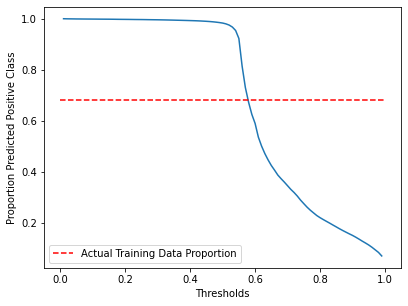

In [122]:
plt.plot(thresholds, thresh_lr_preds)
plt.xlabel("Thresholds")
plt.ylabel("Proportion Predicted Positive Class")
plt.plot([0, 1], [np.mean(y_small_train), np.mean(y_small_train)], color="red", linestyle="--", 
        label = 'Actual Training Data Proportion')
plt.legend(loc="lower left")

In [123]:
idx = np.where(thresh_lr_preds < np.mean(y_small_train))[0][0] # first index where threshold is sufficiently large
idx

57

In [124]:
new_thresh = thresholds[idx]
new_thresh

0.58

In [125]:
lr_small_preds_newthresh = (lr_small_predprobs > new_thresh)
np.mean(lr_small_preds_newthresh == y_small_test)

0.7755235932374464

Finally we see an improvement over the baseline with a threshold of 0.58 resulting in an accuracy of 0.776 (3 s.f.) verus the baseline of 0.682 (3 s.f.).

We now try calculating the test set accuracy across thresholds to see whether this was indeed close to optimal, though this should not be done for hyperparameter tuning due to overfitting. 

In [126]:
thresh_lr_accs = []
for threshold in thresholds:
  lr_small_preds_thresh = (lr_small_predprobs > threshold)
  thresh_lr_accs.append(np.mean(lr_small_preds_thresh == y_small_test))

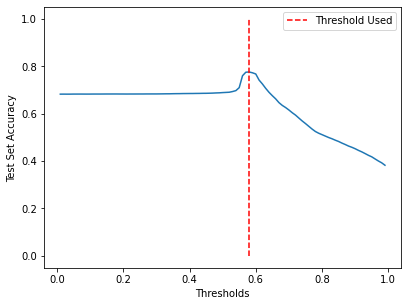

In [127]:
plt.plot(thresholds, thresh_lr_accs)
plt.xlabel("Thresholds")
plt.ylabel("Test Set Accuracy")
plt.plot([new_thresh, new_thresh], [0,1], color="red", linestyle="--", 
        label = 'Threshold Used')
plt.legend()

In [128]:
thresholds[np.argmax(thresh_lr_accs)]

0.58

The maximum test set accuracy is actually achieved with a 0.58 threshold. So picking our threshold for predictions to match the proportion of positive class labels in the training data, leads to the optimal accuracy on the test set.

In [129]:
thresh_lr_f1 = []
for threshold in thresholds:
  lr_small_preds_thresh = (lr_small_predprobs > threshold)
  thresh_lr_f1.append(f1_score(y_small_test, lr_small_preds_thresh))

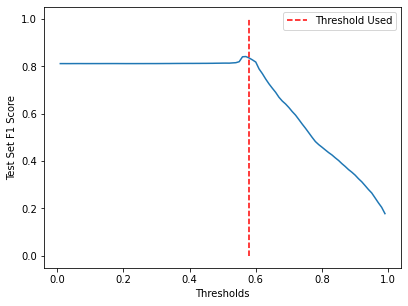

In [130]:
plt.plot(thresholds, thresh_lr_f1)
plt.xlabel("Thresholds")
plt.ylabel("Test Set F1 Score")
plt.plot([new_thresh, new_thresh], [0,1], color="red", linestyle="--", 
        label = 'Threshold Used')
plt.legend()

In [131]:
thresholds[np.argmax(thresh_lr_f1)]

0.57

In [132]:
np.max(thresh_lr_f1) 

0.8406107305936071

In [133]:
thresh_lr_f1[np.argmax(thresh_lr_f1) + 1]

0.8345484302931111

 Here the optimal F$_{1}$ score on the test set as at the threshold 0.57 instead of 0.58 with a small drop off at 0.58 to 0.835 (3 s.f.) from 0.841 (3 s.f.) but it is still very close. So our intuition of the best threshold determined from the training data is further supported.

The graph highlights that the F$_{1}$ score may not be an appropriate metric for this data set as close to optimal scores of above 0.8 are achieved with even trivial thresholds. The benchmark classifier also illustrates this.

In [134]:
all_ones_small = len(y_small_test) * [1]
f1_bench_small = f1_score(y_small_test, all_ones_small)
f1_bench_small

0.8105885530778235

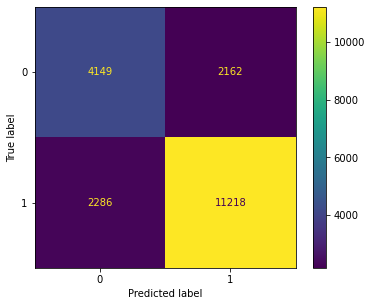

In [135]:
cm_lr_small_thresh = confusion_matrix(y_small_test, lr_small_preds_newthresh)
disp = ConfusionMatrixDisplay(cm_lr_small_thresh)
disp.plot(values_format='')

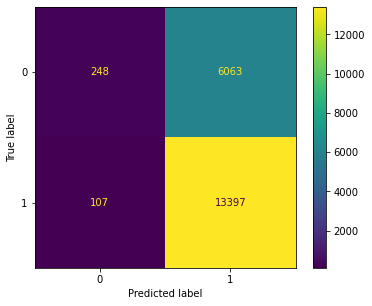

In [136]:
cm_lr_small = confusion_matrix(y_small_test, lr_small_preds)
disp = ConfusionMatrixDisplay(cm_lr_small)
disp.plot(values_format='')

Comparing the confusion matrices, we see that using the 0.58 threshold (top) doesn't miss almost completely on the 0 true labels compared to the 0.5 threshold. The 0.5 threshold is very similar to a classifier that just predicts the majority class. 

In [137]:
roc_lr_small_dat = roc_curve(y_small_test, lr_small_predprobs)
auc_lr_small = roc_auc_score(y_small_test, lr_small_predprobs)
auc_lr_small

0.8214885278919453

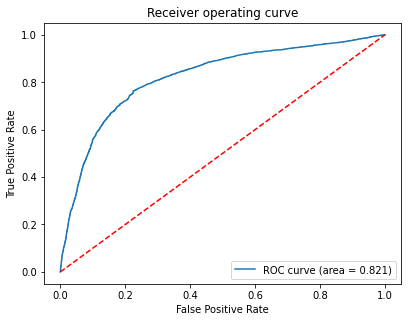

In [138]:
plt.plot(roc_lr_small_dat[0], roc_lr_small_dat[1], label="ROC curve (area = %0.3f)" % auc_lr_small)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating curve")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")


The ROC curve has an area under the curve (AUC) of 0.821 (3.s.f). This was the only decent performing metric when logistic regression was used on the larger data set and this still outperforms.


# Generalization of Model on Reduced Data Set to Larger Data Set

Now we see how this logistic regression model with severe outliers removed generalizes to the larger data set where the outliers are included.

In [139]:
lr_small_to_large_predprobs = lr.predict_proba(X_large_test)[:,1]
lr_large_preds_newthresh = (lr_small_to_large_predprobs > new_thresh)
lr_small_newthresh_to_large_acc = np.mean(y_large_test == lr_large_preds_newthresh)
lr_small_newthresh_to_large_acc

0.8247099613281771

In [140]:
lr_small_newthresh_to_large_f1 = f1_score(y_large_test, lr_large_preds_newthresh)
lr_small_newthresh_to_large_f1

0.8852566340782123

In [141]:
roc_lr_small_to_large_dat = roc_curve(y_large_test, lr_small_to_large_predprobs)
auc_lr_small_to_large = roc_auc_score(y_large_test, lr_small_to_large_predprobs)
auc_lr_small_to_large

0.8341442422166109

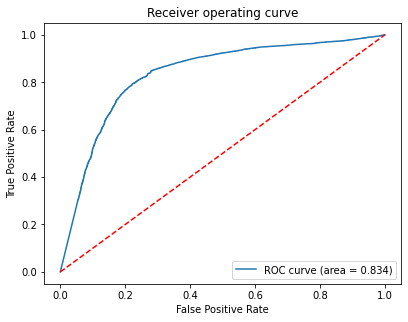

In [142]:
plt.plot(roc_lr_small_to_large_dat[0], roc_lr_small_to_large_dat[1], label="ROC curve (area = %0.3f)" % auc_lr_small_to_large)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating curve")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

Across the board there are improvements however note the train and test sets are different between the small (absolute value below 1000) and large (absolute value below $10^{10}$) and so there may be some data leakage but it's unlikely this explains the improved performance of training on the smaller data set.

In [143]:
lr.score(X_large_train, y_large_train)

0.7680627942554665

In [144]:
lr.score(X_large_test, y_large_test)

0.7645352713695159

In [145]:
lr.score(X_small_train, y_small_train)

0.6887217792133509

In [146]:
lr.score(X_small_test, y_small_test)

0.6886197325258643

Given the above where there is no difference between train and test sets in both the small and large data set, data leakage is not a valid explanation on how the reduced data set model is able to generalize well to the larger data set. 


# AdaBoost

 
Outside of logistic regression, we consider other algorithms and try to understand the impact of outliers on performance and the generalizability to outliers from a model with outliers removed. We begin with AdaBoost and suspect it to be less sensitive than logistic regression to outliers where theoretical underpinnings for why logistic regression would struggle were clear. Outliers do have some impact on AdaBoost based on the literature but generally tree based models are less susceptible.  No hyperparameter tuning here is conducted as the above questions are our main interest versus optimizing model performance. 100 estimators are used as this is the default for XGBoost (which will be tried next).


In [167]:
ab = AdaBoostClassifier(n_estimators=100, random_state=0) # not fit so can be reused and random_state set for reproducbility
ab.fit(X_large_train, y_large_train)
ab_large_acc = ab.score(X_large_test, y_large_test)
ab_large_acc

0.838578477130284

In [168]:
ab.fit(X_small_train, y_small_train)
ab_small_acc = ab.score(X_small_test, y_small_test)
ab_small_acc

0.7901085036588443

In [149]:
ab_small_to_large_acc = ab.score(X_large_test, y_large_test)
ab_small_to_large_acc

0.7078943859181224

Unlike with logistic regression, there do not appear to be any issues with outliers in AdaBoost and the smaller data set cannot generalize to the larger data set.

In [150]:
ab.fit(X_large_train, y_large_train) # refit to large data set 
ab_large_preds = ab.predict(X_large_test)
ab_large_f1 = f1_score(y_large_test, ab_large_preds)
ab_large_f1

0.8964366685203405

In [151]:
ab.fit(X_small_train, y_small_train)
ab_small_preds = ab.predict(X_small_test)
ab_small_f1 = f1_score(y_small_test, ab_small_preds)
ab_small_f1

0.8496873757634897

In [152]:
ab_small_to_large_preds = ab.predict(X_large_test)
ab_small_to_large_f1 = f1_score(y_large_test, ab_small_to_large_preds)
ab_small_to_large_f1

0.792997542997543

Again the smaller data set is not able to generalize to the larger one per the F$_{1}$ score. AdaBoost seems robust to outliers.

In [186]:
ab.fit(X_large_train, y_large_train)
ab_large_predprobs = ab.predict_proba(X_large_test)[:,1]
auc_ab_large = roc_auc_score(y_large_test, ab_large_predprobs)
auc_ab_large

0.8653820131825691

In [187]:
ab.fit(X_small_train, y_small_train)
ab_small_predprobs = ab.predict_proba(X_small_test)[:,1]
auc_ab_small = roc_auc_score(y_small_test, ab_small_predprobs)
auc_ab_small

0.845311747862192

In [189]:
ab_small_to_large_predprobs = ab.predict_proba(X_large_test)[:,1]
auc_ab_small_to_large = roc_auc_score(y_large_test, ab_small_to_large_predprobs)
auc_ab_small_to_large

0.7469219850225496

A similar story is told with AUC, with good performance but inability to generalize to the larger data set using the model fitted on the smaller one.

# XGBoost

A similar procedure to what has been conducted for AdaBoost is now done for XGBoost with 100 estimators also used.  

In [172]:
xgb = XGBClassifier(n_estimators=100, random_state=0) # not fit so can be reused and random_state set for reproducbility
xgb.fit(X_large_train, y_large_train)
xgb_large_acc = xgb.score(X_large_test, y_large_test)
xgb_large_acc

0.8601146819575943

In [173]:
xgb.fit(X_small_train, y_small_train)
xgb_small_acc = xgb.score(X_small_test, y_small_test)
xgb_small_acc

0.8259399444865001

In [174]:
xgb_small_to_large_acc = xgb.score(X_large_test, y_large_test)
xgb_small_to_large_acc

0.8629150553407121

Unlike AdaBoost, XGBoost actually does allow for good generalization from the smaller model and also has the best performance on both data sets with respect to accuracy.

In [175]:
xgb.fit(X_large_train, y_large_train) # refit to larger data set
xgb_large_preds = xgb.predict(X_large_test)
xgb_large_f1 = f1_score(y_large_test, xgb_large_preds)
xgb_large_f1

0.9099416208791209

In [176]:
xgb.fit(X_small_train, y_small_train)
xgb_small_preds = xgb.predict(X_small_test)
xgb_small_f1 = f1_score(y_small_test, xgb_small_preds)
xgb_small_f1

0.8741286814349842

In [177]:
xgb_small_to_large_preds = xgb.predict(X_large_test)
xgb_small_to_large_f1 = f1_score(y_large_test, xgb_small_to_large_preds)
xgb_small_to_large_f1

0.9114975679049545

Again the F$_{1}$ score like with accuracy for XGBoost improves using inference made from the model on the smaller data set to the larger one. Additionally XGBoost performs best across the board on F$_{1}$ scores as was the case with accuracy. 

In [190]:
xgb.fit(X_large_train, y_large_train)
xgb_large_predprobs = xgb.predict_proba(X_large_test)[:,1]
auc_xgb_large = roc_auc_score(y_large_test, xgb_large_predprobs)
auc_xgb_large

0.8982091430103811

In [191]:
xgb.fit(X_small_train, y_small_train)
xgb_small_predprobs = xgb.predict_proba(X_small_test)[:,1]
auc_xgb_small = roc_auc_score(y_small_test, xgb_small_predprobs)
auc_xgb_small

0.8863110555199265

In [192]:
xgb_small_to_large_predprobs = xgb.predict_proba(X_large_test)[:,1]
auc_xgb_small_to_large = roc_auc_score(y_large_test, xgb_small_to_large_predprobs)
auc_xgb_small_to_large

0.8896847526696368

AUC is also highest for both data sets for XGBoost with minimal drop in performance when the model fit on the smaller data set is used for inference on the larger data set.


# Results Summary

The tables below summarizes results for both the large data sets across the models we have tried. The top table is for the larger data set. All values are to 3 significant figures.

|Metric|All Pos. Bench.|LR w/ outliers|LR w/ thresh. adj.|AdaBoost, n_est=100|AdaBoost small to large|XGBoost, n_est=100|XGBoost small to large|
|:----|:--------|:--------|:--------|:--------|:--------|:--------|:--------:|
|Accuracy|0.760|0.759|0.825|0.839|0.708|0.860|0.863|
|F$_{1}$|0.865|0.855|0.885|0.896|0.793|0.910|0.911|
|AUC|0.500|0.787|0.834|0.865|0.747|0.898|0.886|


|Metric|All Pos. Bench.|LR w/ thresh. adj.|AdaBoost, n_est=100|XGBoost, n_est=100|
|:----|:--------|:--------|:--------|:--------:|
|Accuracy|0.682|0.776|0.790|0.826|
|F$_{1}$|0.811|0.835|0.850|0.874|
|AUC|0.500|0.821|0.845|0.890|


XGBoost performs best across metrics on all data sets with the smaller data set generalizing well and outperforming fitting directly on the larger data set on all but the AUC. AdaBoost without outliers cannot make inference on the outliers and performs worse than benchmarks except for AUC and logistic regression with outliers across all metrics. Representative data appears to be important for AdaBoost comparatively.  


# Conclusion

While using logistic regression, it appears handling outliers is important otherwise model performance suffers. Large sequence values led to the weights becoming very small.  Reasonably good predictions of whether the tenth value was larger than the ninth on removed out-of-distribution sequences was still possible though once threshold moving was used to tune the threshold on the smaller data set.  This generalizability was also possible with XGBoost but not with AdaBoost, though both were able to handle outliers in model fitting better than logistic regression. 
 

Some further work can be done with regards to understanding the impact of standard transforms on sequence data such as differencing or log-transforms (as skew was present here) and which models benefit, which are agnostic and which perform worse. Additionally, which algorithms benefit from all nine sequence values versus only needing a subset (eighth and ninth only for example) would be another avenue of research.


# References

(Sloane, 1964) https://oeis.org/ 

 (Bieber, 2020) https://davidbieber.com/snippets/2020-06-28-oeis-download/ 

Threshold moving, https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
